In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
print(os.listdir("/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates"))
# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/')
    
print('After zip extraction:')
print(os.listdir("/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/"))

['platesv2.zip', 'working']
After zip extraction:
['plates.zip', 'sample_submission.csv', 'plates', '__MACOSX']


In [ ]:
data_root = '/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/plates'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [ ]:
import shutil 
from tqdm import tqdm


train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 536.26it/s]


In [ ]:
!ls train

cleaned  dirty


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = 15, 45

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0].permute(1, 2, 0).numpy() * std + mean )for _ in range(n)))
                   for i in range(len(dataset))))
    
    plt.imshow(img)
    plt.axis('off')

In [ ]:
import torch
import numpy as np
import torchvision
 
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    
    
    transforms.RandomChoice(transforms = [transforms.ColorJitter(brightness=0.0, contrast=0, saturation=0, hue=0),
                                         transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.21, hue=0.15)
                                          ]),
     
    
    transforms.RandomChoice(transforms = [transforms.RandomRotation(degrees = 80), transforms.RandomRotation(degrees = 90)]),
    transforms.RandomChoice(transforms = [transforms.CenterCrop((224,224)),transforms.RandomCrop((224,224))]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


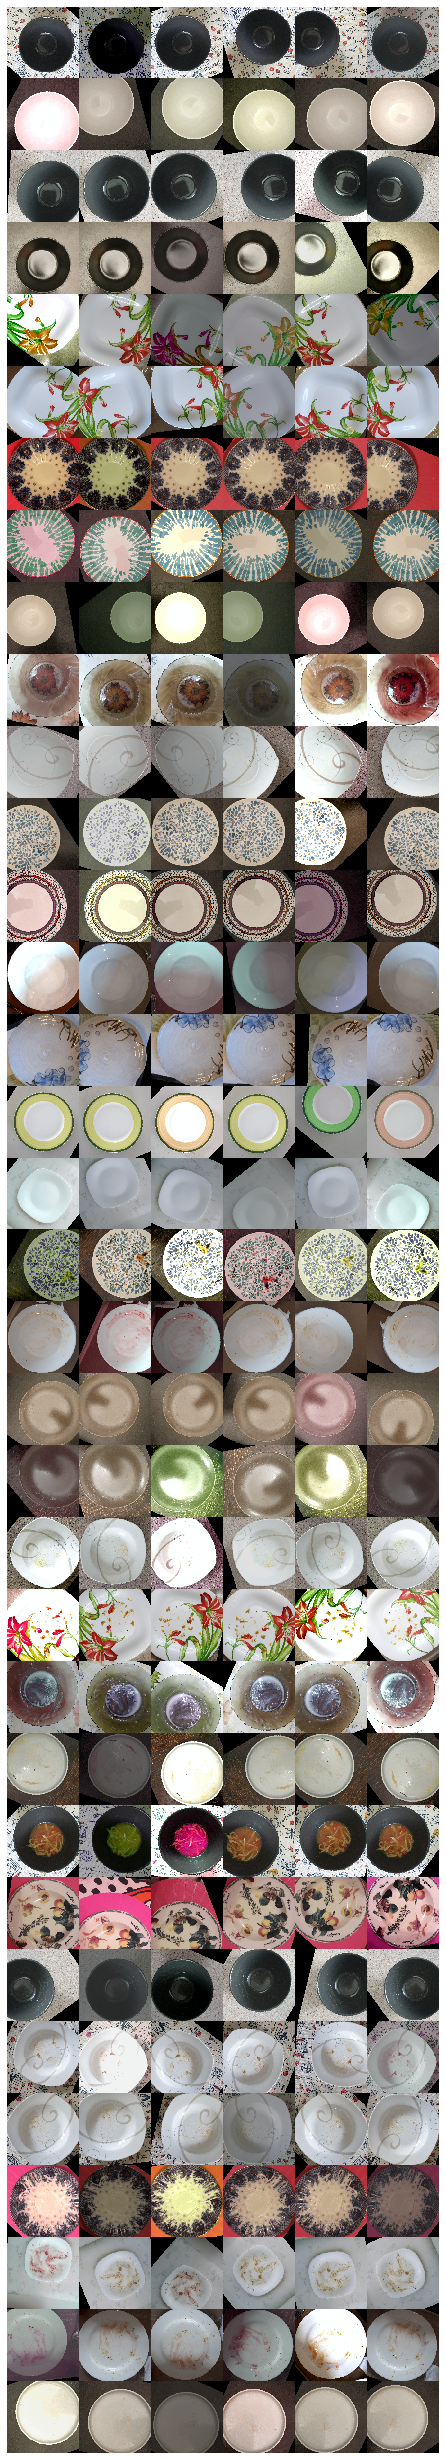

In [ ]:
# torch.cuda.is_available()
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
show_dataset(train_dataset)

In [ ]:
len(train_dataloader), len(train_dataset)

(5, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


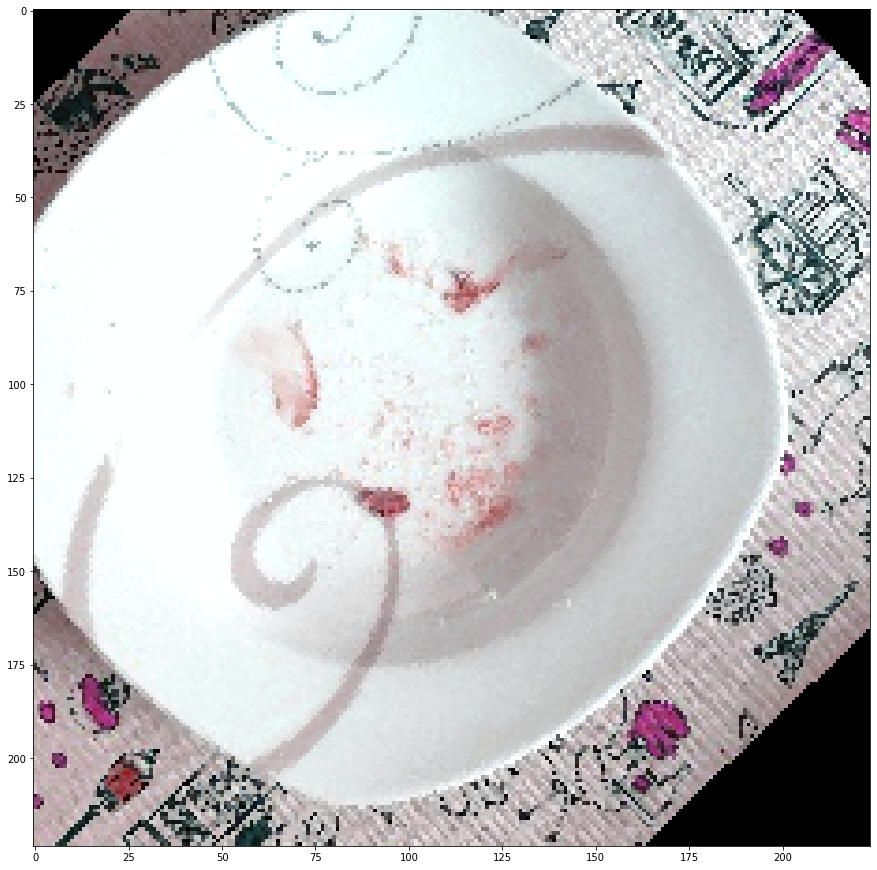

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

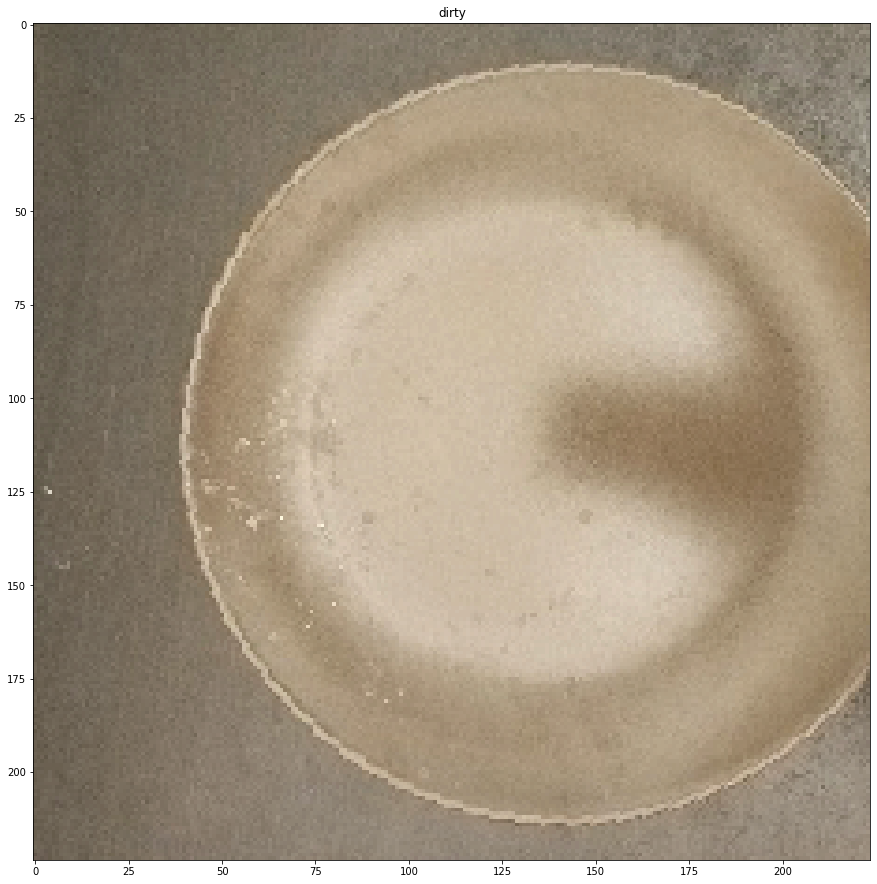

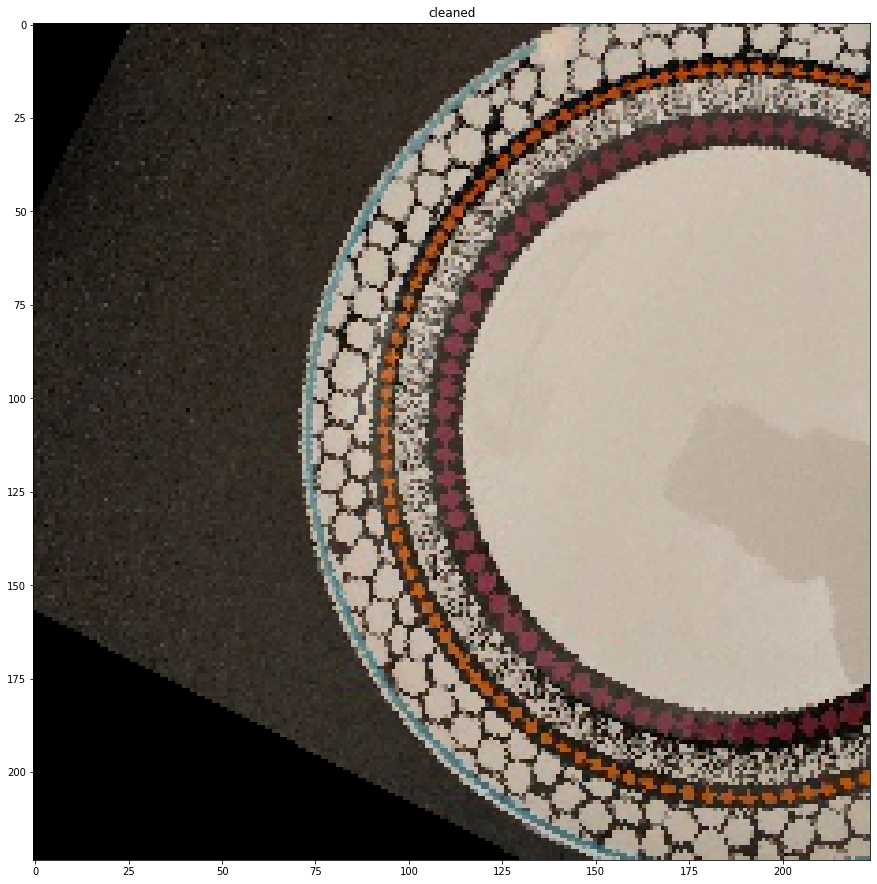

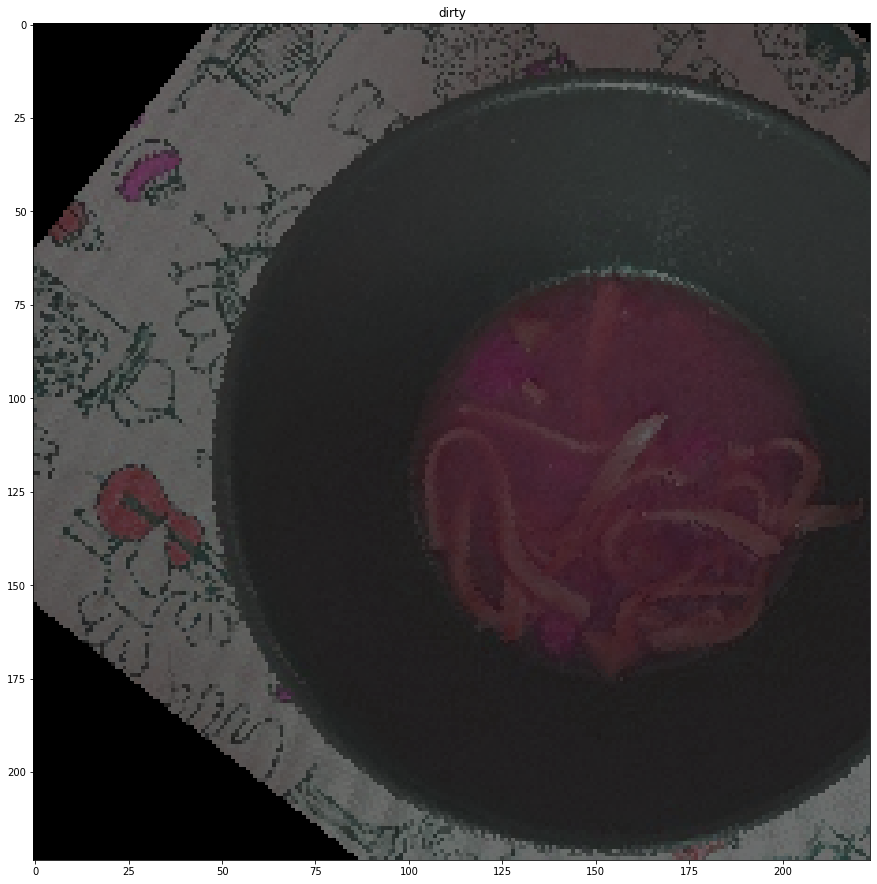

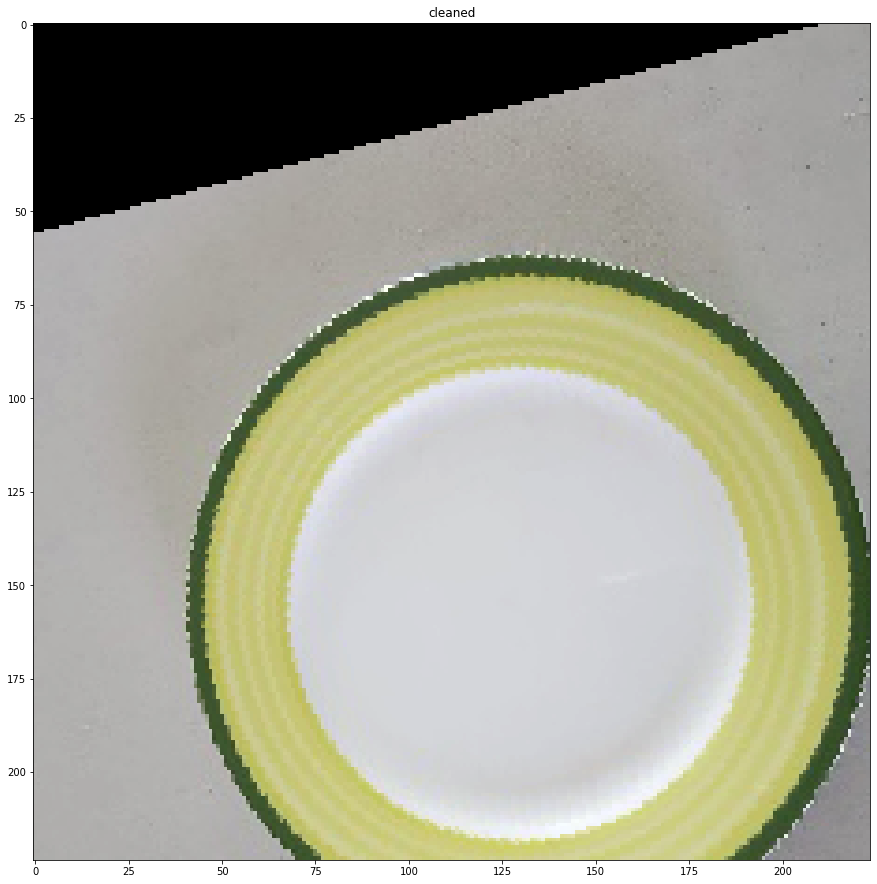

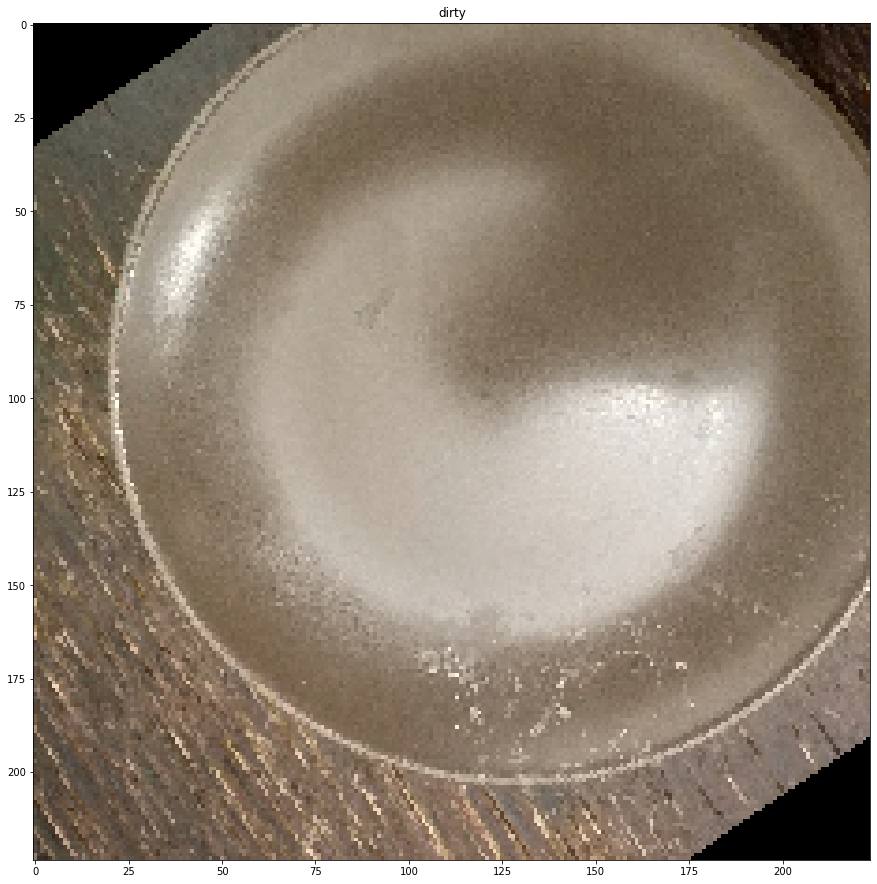

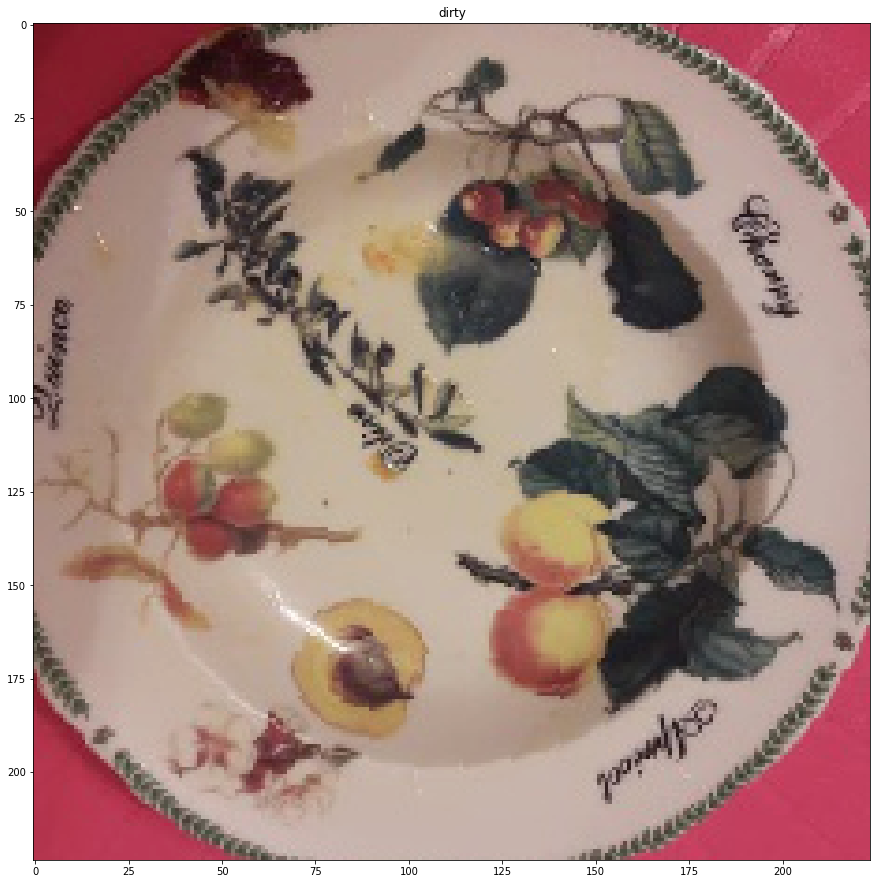

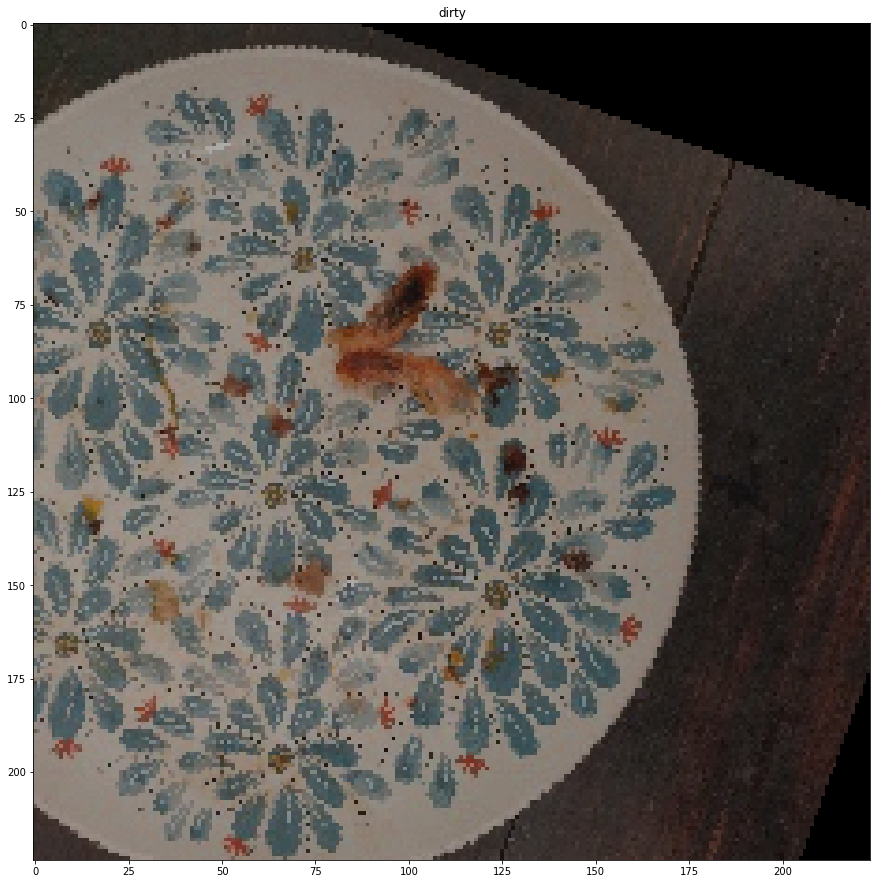

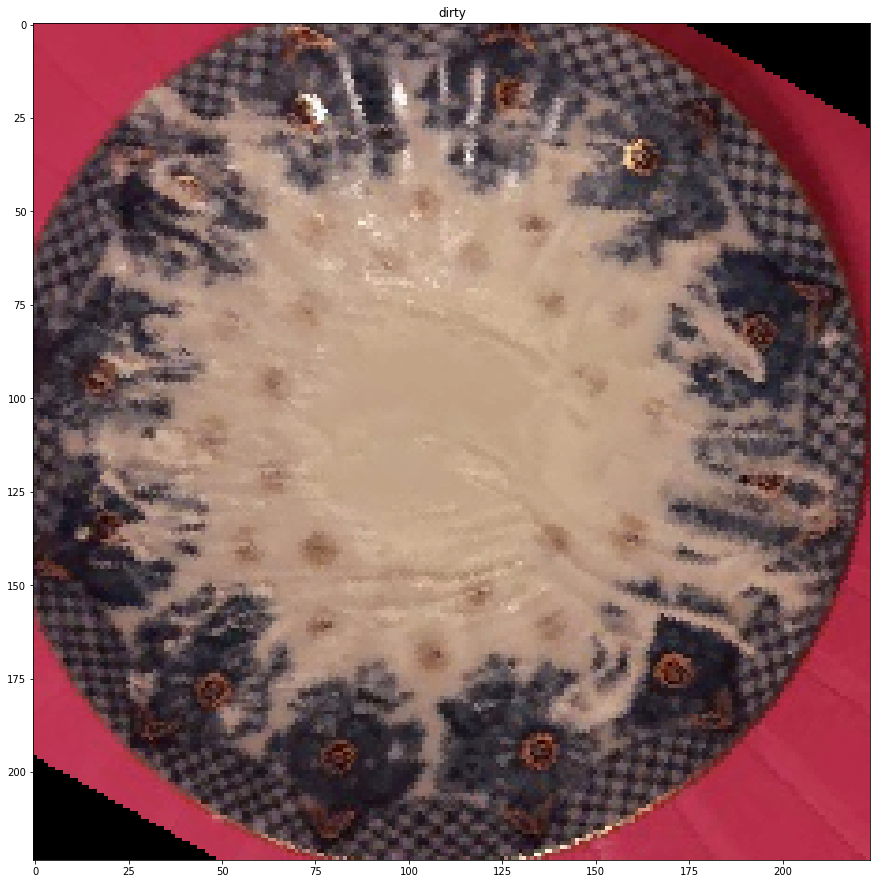

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    epoch_loss_hist = []
    epoch_acc_hist = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            epoch_loss_hist.append(epoch_loss)
            epoch_acc_hist.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, epoch_loss_hist, epoch_acc_hist

In [ ]:
torch.cuda.is_available()

True

In [ ]:

model = models.vgg16(pretrained=True)

for param in model.features.parameters(): # we train the weights only of the last layers
    param.requires_grad = False

model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# model = models.vgg16(pretrained=True)
# #models.resnet18(pretrained=True)

# # Disable grad for all conv layers
# for param in model.parameters():
#     param.requires_grad = False

# model.fc = torch.nn.Linear(model.fc.in_features, 2)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# # Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
model, epoch_loss_hist, epoch_acc_hist = train_model(model, loss, optimizer, scheduler, num_epochs=70);

Epoch 0/69:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

train Loss: 505.7077 Acc: 0.4750



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 533.6741 Acc: 0.5000
Epoch 1/69:



100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

train Loss: 395.0634 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 1032.3644 Acc: 0.5000
Epoch 2/69:



100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

train Loss: 688.4841 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 212.6582 Acc: 0.5000
Epoch 3/69:



100%|██████████| 5/5 [00:01<00:00,  4.97it/s]

train Loss: 139.3666 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 53.4308 Acc: 0.6667
Epoch 4/69:



100%|██████████| 5/5 [00:00<00:00,  5.18it/s]

train Loss: 92.4118 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 84.7140 Acc: 0.5000
Epoch 5/69:



100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

train Loss: 78.9730 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 371.7882 Acc: 0.5000
Epoch 6/69:



100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

train Loss: 269.5004 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 85.5887 Acc: 0.8333
Epoch 7/69:



100%|██████████| 5/5 [00:00<00:00,  5.12it/s]

train Loss: 154.7126 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 20.3169 Acc: 0.8333
Epoch 8/69:



100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

train Loss: 33.1113 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 37.0533 Acc: 0.8333
Epoch 9/69:



100%|██████████| 5/5 [00:00<00:00,  5.13it/s]

train Loss: 128.5625 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

val Loss: 13.0860 Acc: 0.8333
Epoch 10/69:



100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

train Loss: 87.1013 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 18.5770 Acc: 0.6667
Epoch 11/69:



100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

train Loss: 51.7302 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 2.3750 Acc: 0.8333
Epoch 12/69:



100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

train Loss: 54.6540 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 21.8696 Acc: 0.8333
Epoch 13/69:



100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

train Loss: 44.9757 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 20.3757 Acc: 0.8333
Epoch 14/69:



100%|██████████| 5/5 [00:00<00:00,  5.10it/s]

train Loss: 32.2889 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 25.5962 Acc: 0.8333
Epoch 15/69:



100%|██████████| 5/5 [00:01<00:00,  4.65it/s]

train Loss: 37.2991 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 18.6471 Acc: 0.8333
Epoch 16/69:



100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

train Loss: 44.3294 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 5.6596 Acc: 0.8333
Epoch 17/69:



100%|██████████| 5/5 [00:01<00:00,  4.65it/s]

train Loss: 15.3779 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

val Loss: 4.0397 Acc: 0.8333
Epoch 18/69:



100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

train Loss: 28.8716 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 15.7882 Acc: 0.8333
Epoch 19/69:



100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

train Loss: 6.8600 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 17.2269 Acc: 0.8333
Epoch 20/69:



100%|██████████| 5/5 [00:01<00:00,  4.92it/s]

train Loss: 24.8356 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 18.2476 Acc: 0.8333
Epoch 21/69:



100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

train Loss: 17.0527 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 18.8903 Acc: 0.8333
Epoch 22/69:



100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

train Loss: 60.6394 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 17.8766 Acc: 0.8333
Epoch 23/69:



100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

train Loss: 64.0181 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 15.1005 Acc: 0.8333
Epoch 24/69:



100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

train Loss: 47.3979 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 13.8058 Acc: 0.8333
Epoch 25/69:



100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

train Loss: 63.2903 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 14.5392 Acc: 0.8333
Epoch 26/69:



100%|██████████| 5/5 [00:00<00:00,  5.00it/s]

train Loss: 164.0701 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 14.9182 Acc: 0.8333
Epoch 27/69:



100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

train Loss: 52.4794 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 15.1842 Acc: 0.8333
Epoch 28/69:



100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

train Loss: 72.1687 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 16.0211 Acc: 0.8333
Epoch 29/69:



100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

train Loss: 31.6502 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 16.0235 Acc: 0.8333
Epoch 30/69:



100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

train Loss: 37.4059 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

val Loss: 15.9522 Acc: 0.8333
Epoch 31/69:



100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

train Loss: 26.9243 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 16.0016 Acc: 0.8333
Epoch 32/69:



100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

train Loss: 54.0931 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 16.0112 Acc: 0.8333
Epoch 33/69:



100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

train Loss: 40.1896 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 15.9479 Acc: 0.8333
Epoch 34/69:



100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

train Loss: 26.4431 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 16.0414 Acc: 0.8333
Epoch 35/69:



100%|██████████| 5/5 [00:01<00:00,  4.67it/s]

train Loss: 46.5157 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 16.0540 Acc: 0.8333
Epoch 36/69:



100%|██████████| 5/5 [00:01<00:00,  4.78it/s]

train Loss: 33.1805 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

val Loss: 16.0628 Acc: 0.8333
Epoch 37/69:



100%|██████████| 5/5 [00:01<00:00,  5.00it/s]

train Loss: 23.4041 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

val Loss: 16.0744 Acc: 0.8333
Epoch 38/69:



100%|██████████| 5/5 [00:00<00:00,  5.03it/s]

train Loss: 55.9255 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 16.1306 Acc: 0.8333
Epoch 39/69:



100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

train Loss: 85.8580 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 16.1312 Acc: 0.8333
Epoch 40/69:



100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

train Loss: 48.2824 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

val Loss: 16.1276 Acc: 0.8333
Epoch 41/69:



100%|██████████| 5/5 [00:00<00:00,  5.09it/s]

train Loss: 46.0827 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 16.1221 Acc: 0.8333
Epoch 42/69:



100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

train Loss: 36.6520 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

val Loss: 16.1212 Acc: 0.8333
Epoch 43/69:



100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

train Loss: 39.2243 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 16.1103 Acc: 0.8333
Epoch 44/69:



100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

train Loss: 76.2874 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 16.1023 Acc: 0.8333
Epoch 45/69:



100%|██████████| 5/5 [00:01<00:00,  4.99it/s]

train Loss: 26.8567 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

val Loss: 16.1039 Acc: 0.8333
Epoch 46/69:



100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

train Loss: 43.0959 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

val Loss: 16.1094 Acc: 0.8333
Epoch 47/69:



100%|██████████| 5/5 [00:01<00:00,  4.92it/s]

train Loss: 17.2218 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 16.1127 Acc: 0.8333
Epoch 48/69:



100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

train Loss: 20.2779 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

val Loss: 16.1102 Acc: 0.8333
Epoch 49/69:



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

train Loss: 44.1691 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

val Loss: 16.1096 Acc: 0.8333
Epoch 50/69:



100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

train Loss: 30.9891 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 16.1110 Acc: 0.8333
Epoch 51/69:



100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

train Loss: 20.5669 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 16.1114 Acc: 0.8333
Epoch 52/69:



100%|██████████| 5/5 [00:01<00:00,  4.92it/s]

train Loss: 36.1267 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 16.1116 Acc: 0.8333
Epoch 53/69:



100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

train Loss: 81.3393 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

val Loss: 16.1126 Acc: 0.8333
Epoch 54/69:



100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

train Loss: 40.1984 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

val Loss: 16.1127 Acc: 0.8333
Epoch 55/69:



100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

train Loss: 114.5469 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 16.1130 Acc: 0.8333
Epoch 56/69:



100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

train Loss: 17.5681 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

val Loss: 16.1127 Acc: 0.8333
Epoch 57/69:



100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

train Loss: 3.9225 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 16.1122 Acc: 0.8333
Epoch 58/69:



100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

train Loss: 91.1490 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 16.1118 Acc: 0.8333
Epoch 59/69:



100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

train Loss: 91.7393 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 16.1119 Acc: 0.8333
Epoch 60/69:



100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

train Loss: 22.5972 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

val Loss: 16.1120 Acc: 0.8333
Epoch 61/69:



100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

train Loss: 47.7997 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

val Loss: 16.1119 Acc: 0.8333
Epoch 62/69:



100%|██████████| 5/5 [00:01<00:00,  4.78it/s]

train Loss: 6.1800 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 16.1118 Acc: 0.8333
Epoch 63/69:



100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

train Loss: 28.2349 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 16.1117 Acc: 0.8333
Epoch 64/69:



100%|██████████| 5/5 [00:00<00:00,  5.09it/s]

train Loss: 81.8539 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 16.1116 Acc: 0.8333
Epoch 65/69:



100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

train Loss: 23.4370 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

val Loss: 16.1114 Acc: 0.8333
Epoch 66/69:



100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

train Loss: 19.0160 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 16.1114 Acc: 0.8333
Epoch 67/69:



100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

train Loss: 34.6836 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

val Loss: 16.1115 Acc: 0.8333
Epoch 68/69:



100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

train Loss: 85.1560 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

val Loss: 16.1115 Acc: 0.8333
Epoch 69/69:



100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

train Loss: 50.8076 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

val Loss: 16.1115 Acc: 0.8333


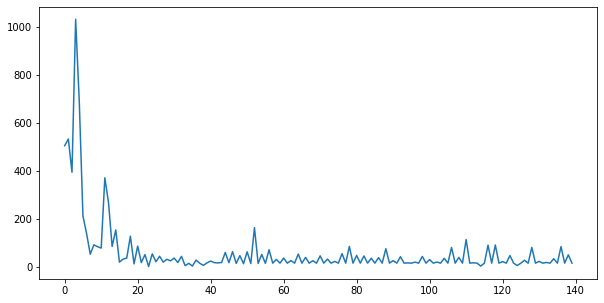

In [ ]:
plt.rcParams['figure.figsize'] = 10, 5
plt.plot(epoch_loss_hist)


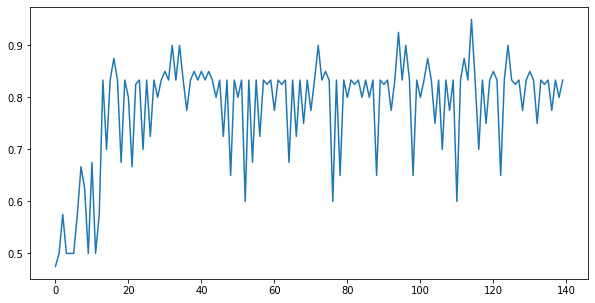

In [ ]:
plt.plot(epoch_acc_hist)

In [ ]:
test_dir = '/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/plates/test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: ignored

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/plates/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)


In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/drive/MyDrive/Python_Scripts/HW05_Milenkin/plates/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test

In [ ]:
test_predictions